# 1. Project Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mode


In [2]:
# Set display options to show all columns/rows and suppress scientific notation for floats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings("ignore")

# --- Data Loading ---

In [115]:
# Assuming the file is named 'Insurance Data.xlsx' in the current working directory
try:
    data = pd.read_excel(r"D:\Naresh IT\fwdinsuranceproject (1)\Insurance Data.xlsx")
except FileNotFoundError:
    print("Error: Insurance Data.xlsx not found. Please ensure the file is in the correct directory.")


# --- Initial Data Prep ---

In [116]:
# Clean column names (replace spaces with underscores)
data.columns = [re.sub(r'[\s/]+', '_', x.strip()) for x in data.columns]

# Display initial shape and first few rows
print(f"Initial Shape: {data.shape}")
print("First 5 rows of the dataset:")
data.head()


Initial Shape: (100000, 16)
First 5 rows of the dataset:


,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,18.00,M,Single,3.00,NE,SPT,DD,1.00,No,NO,0.00,INV,15000000.00,Cold,Converted,Converted
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,NotConverted,AS
2,23.00,M,Married,2.00,BD,SPT,PG,9.00,No,NO,0.00,ANS,1000000.00,Hot,Converted,Converted
3,20.00,M,Single,6.00,NE,SPT,OM,2.42,No,NO,0.00,END,1000000.00,Warm,Converted,Converted
4,48.00,NaN,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,NotConverted,PS


# 2. Data Understanding and Missing Values

Let's check for missing values to understand where we need to apply the cleaning strategies.

In [117]:
print("Missing values before cleaning:")
print(data.isnull().sum())

Missing values before cleaning:
Age                      44
Gender                  182
Marital_Status           42
Family_Members           22
Education                46
Occupation               43
Job_Title               123
Income                   98
Current_Product          18
Current_Product_Type     33
Current_Coverage         49
New_Product_Type         47
New_Coverage            127
Rating                   44
Converted                49
Status                    0
dtype: int64


All variables except Status have missing values, but the report indicates specific strategies for most of them.

## Data Engineering Strategy (from provided document)

We will implement the imputation based on the following general strategy:
1. **Simple Imputation (Mean/Median/Mode):** For most standalone variables.
2. **Complex Imputation (Group-wise Mean/Median/Mode):** For Income, Current_Coverage, and New_Coverage.
3. **Conditional Imputation (Business Logic):** For Current_Product, Current_Product_Type, Current_Coverage.
4. **Target Variable:** Drop missing Converted rows.
5. **Feature Selection:** Drop Gender and Marital_Status (as in the code snippet).

# 3. Data Cleaning and Preprocessing

## Handling Simple Missing Values (Age, Family_Members, Categorical)

### Age

Strategy: Calculate Mean and Median, Choose the lowest value (which is 39.0)

In [118]:
age_mean = data['Age'].mean()
age_median = data['Age'].median()
print(age_mean, age_median)

39.02571131297771 39.0


In [119]:
replacement = age_mean if age_mean < age_median else age_median
replacement

39.0

In [120]:
data['Age'].fillna(replacement, inplace=True)
print(f"Age missing values filled with median: {age_median}")

Age missing values filled with median: 39.0


In [121]:
data['Age'].isnull().sum()

np.int64(0)

### Family_Members

Missing Values were imputed by considering the minimum value between the mean
and median values which were calculated excluding the missing data

In [122]:
fm_mean = data['Family_Members'].mean()
fm_median = data['Family_Members'].median()
print(fm_mean, fm_median)
replacement = fm_mean if fm_mean < fm_median else fm_median
replacement

4.659405069115206 4.0


4.0

In [123]:
print("The value used fo replacement", replacement)
data['Family_Members'].fillna(replacement, inplace=True)

print(f"Family_Members missing values filled with median: {replacement}")

The value used fo replacement 4.0
Family_Members missing values filled with median: 4.0


In [124]:
data.dtypes

Age                     float64
Gender                   object
Marital_Status           object
Family_Members          float64
Education                object
Occupation               object
Job_Title                object
Income                  float64
Current_Product          object
Current_Product_Type     object
Current_Coverage        float64
New_Product_Type         object
New_Coverage            float64
Rating                   object
Converted                object
Status                   object
dtype: object

### Education, Occupation, Job_Title, New_Product_Type, Rating: Replace with Mode

In [125]:
categorical_cols = ['Education', 'Occupation', 'Job_Title', 'New_Product_Type', 'Rating']
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)
    print(f"Variable {col} missing values filled with mode: {data[col].mode()[0]}")

Variable Education missing values filled with mode: BD
Variable Occupation missing values filled with mode: SPT
Variable Job_Title missing values filled with mode: FH
Variable New_Product_Type missing values filled with mode: ANS
Variable Rating missing values filled with mode: Cold


## Handling Income Missing Values (Grouped Mean/Median)

In [126]:
# Get mean and median grouped by Occupation
income_mean = data.groupby('Occupation')['Income'].mean()
income_median = data.groupby('Occupation')['Income'].median()

In [127]:
income_mean

Occupation
SE    2.95
SFT   2.51
SPT   6.89
Name: Income, dtype: float64

In [128]:
income_median

Occupation
SE    2.32
SFT   2.00
SPT   7.61
Name: Income, dtype: float64

In [129]:
# for occ, mean in income_mean.items():
#     print(occ)
#     print(mean)
#     break

In [130]:
# income_median['SFT']

In [131]:
# c1 = (data['Occupation'] == 'SE') & data['Income'].isna()
# data[c1]

In [132]:
# data.loc[c1, 'Income']

In [133]:
# Apply imputation logic
for occ, mean in income_mean.items():
    median = income_median[occ]

    # Choose the smaller of mean or median
    imputation_value = min(mean, median)

    # Find rows where Occupation matches and Income is missing
    mask = (data['Occupation'] == occ) & (data['Income'].isna())

    # Fill missing values
    data.loc[mask, 'Income'] = imputation_value

    print(f"Occupation: {occ}, Mean: {mean:.2f}, Median: {median:.2f}, Imputed with: {imputation_value:.2f}")

print(f"\nIncome missing values left: {data['Income'].isna().sum()}")

Occupation: SE, Mean: 2.95, Median: 2.32, Imputed with: 2.32
Occupation: SFT, Mean: 2.51, Median: 2.00, Imputed with: 2.00
Occupation: SPT, Mean: 6.89, Median: 7.61, Imputed with: 6.89

Income missing values left: 0


In [134]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,18.00,M,Single,3.00,NE,SPT,DD,1.00,No,NO,0.00,INV,15000000.00,Cold,Converted,Converted
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,NotConverted,AS
2,23.00,M,Married,2.00,BD,SPT,PG,9.00,No,NO,0.00,ANS,1000000.00,Hot,Converted,Converted
3,20.00,M,Single,6.00,NE,SPT,OM,2.42,No,NO,0.00,END,1000000.00,Warm,Converted,Converted
4,48.00,NaN,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,NotConverted,PS


## Handling Interdependent Missing Values (Current Product, Type, Coverage)

This is a multi-step process requiring careful application of business logic.

### Step 1: Impute Current_Product (Yes/No)

**Strategy (from report):** If Current_Product_Type is 'NA' or Current_Coverage is 0, then Current_Product is 'No'. Otherwise, 'Yes'.

Note: Since we are filling in order, Current_Product_Type and Current_Coverage may still have missing values (NaN) at this stage.

#### Step 1: Impute Current_Product

In [23]:
c1 = data['Current_Product'].isna()
data[c1]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
17539,20.00,M,Single,2.00,NE,SPT,DD,6.89,NaN,NO,0.00,PMT,1000000.00,Cold,NotConverted,PW
17577,47.00,M,Married,2.00,MD,SE,FH,2.78,NaN,ANS,15000000.00,TLE,1000000.00,Cold,NotConverted,PS
17615,23.00,M,Single,7.00,BD,SPT,PR,5.10,NaN,INV,50000.00,PMT,4000000.00,Hot,NotConverted,PN
17653,52.00,F,Married,4.00,PD,SE,FH,2.71,NaN,NO,0.00,ANS,15000000.00,Cold,NotConverted,NW
17672,34.00,F,Single,4.00,BD,SPT,RR,9.31,NaN,NO,0.00,TLE,3000000.00,Hot,NotConverted,PS
17691,34.00,F,Married,4.00,PD,SPT,RR,9.37,NaN,TLE,15000000.00,END,15000000.00,Hot,Converted,Converted
17730,34.00,M,Married,10.00,MD,SPT,BA,6.53,NaN,NO,0.00,INV,2000000.00,Hot,Converted,Converted
17749,54.00,M,Married,9.00,MD,SPT,PR,7.63,NaN,ANS,1000000.00,INV,3000000.00,Warm,Converted,Converted
17806,43.00,M,Married,2.00,UHS,SPT,OM,2.96,NaN,NO,0.00,ANS,1000000.00,Cold,NotConverted,PN
17863,48.00,F,Single,6.00,BD,SE,FH,3.00,NaN,NO,0.00,TLE,2000000.00,Cold,NotConverted,PS


In [25]:
data[c1].index

Index([17539, 17577, 17615, 17653, 17672, 17691, 17730, 17749, 17806, 17863,
       17901, 17939, 17977, 18015, 18034, 18091, 18129, 18148],
      dtype='int64')

In [136]:
# Identify rows where Current_Product is missing (NaN)
missing_prod_idx = data[data['Current_Product'].isna()].index
missing_prod_idx

Index([17539, 17577, 17615, 17653, 17672, 17691, 17730, 17749, 17806, 17863,
       17901, 17939, 17977, 18015, 18034, 18091, 18129, 18148],
      dtype='int64')

In [137]:
c1 = (data.loc[missing_prod_idx, 'Current_Product_Type'] == 'NO')

c2 = (data.loc[missing_prod_idx, 'Current_Coverage'] == 0.0)



In [138]:
data.loc[missing_prod_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
17539,20.00,M,Single,2.00,NE,SPT,DD,6.89,NaN,NO,0.00,PMT,1000000.00,Cold,NotConverted,PW
17653,52.00,F,Married,4.00,PD,SE,FH,2.71,NaN,NO,0.00,ANS,15000000.00,Cold,NotConverted,NW
17672,34.00,F,Single,4.00,BD,SPT,RR,9.31,NaN,NO,0.00,TLE,3000000.00,Hot,NotConverted,PS
17730,34.00,M,Married,10.00,MD,SPT,BA,6.53,NaN,NO,0.00,INV,2000000.00,Hot,Converted,Converted
17806,43.00,M,Married,2.00,UHS,SPT,OM,2.96,NaN,NO,0.00,ANS,1000000.00,Cold,NotConverted,PN
17863,48.00,F,Single,6.00,BD,SE,FH,3.00,NaN,NO,0.00,TLE,2000000.00,Cold,NotConverted,PS
17977,42.00,M,Married,6.00,MD,SPT,BA,6.95,NaN,NO,0.00,TLE,1000000.00,Warm,Converted,Converted
18129,31.00,F,Single,6.00,BD,SE,FH,1.95,NaN,NO,0.00,END,1000000.00,Cold,NotConverted,ARS
18148,21.00,F,Single,3.00,LHS,SFT,FH,1.07,NaN,NO,0.00,END,15000000.00,Cold,NotConverted,DR


In [139]:
data.loc[missing_prod_idx][c1 | c2].index

Index([17539, 17653, 17672, 17730, 17806, 17863, 17977, 18129, 18148], dtype='int64')

In [140]:
# --- Scenario 1: No product ---
# If CPT is 'NA' OR CC is 0.0 (or both are missing) -> No
# Note: We assume missing CPT and CC for a missing CP indicates 'No' since they are related
# and 'NO' is the majority class in the full data for CPT.
idx_no = data.loc[missing_prod_idx][(data.loc[missing_prod_idx, 'Current_Product_Type'] == 'NO') | (data.loc[missing_prod_idx, 'Current_Coverage'] == 0.0)].index
data.loc[idx_no, 'Current_Product'] = 'No'

In [141]:
# cross check
data.loc[missing_prod_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
17539,20.00,M,Single,2.00,NE,SPT,DD,6.89,No,NO,0.00,PMT,1000000.00,Cold,NotConverted,PW
17653,52.00,F,Married,4.00,PD,SE,FH,2.71,No,NO,0.00,ANS,15000000.00,Cold,NotConverted,NW
17672,34.00,F,Single,4.00,BD,SPT,RR,9.31,No,NO,0.00,TLE,3000000.00,Hot,NotConverted,PS
17730,34.00,M,Married,10.00,MD,SPT,BA,6.53,No,NO,0.00,INV,2000000.00,Hot,Converted,Converted
17806,43.00,M,Married,2.00,UHS,SPT,OM,2.96,No,NO,0.00,ANS,1000000.00,Cold,NotConverted,PN
17863,48.00,F,Single,6.00,BD,SE,FH,3.00,No,NO,0.00,TLE,2000000.00,Cold,NotConverted,PS
17977,42.00,M,Married,6.00,MD,SPT,BA,6.95,No,NO,0.00,TLE,1000000.00,Warm,Converted,Converted
18129,31.00,F,Single,6.00,BD,SE,FH,1.95,No,NO,0.00,END,1000000.00,Cold,NotConverted,ARS
18148,21.00,F,Single,3.00,LHS,SFT,FH,1.07,No,NO,0.00,END,15000000.00,Cold,NotConverted,DR


In [142]:
data['Current_Product'].isnull().sum()

np.int64(9)

In [143]:
# --- Scenario 2: Existing customer (Yes) ---
# If CP is still missing after above step -> Yes (implying non-NA type and non-zero coverage, even if those are NaN)
data['Current_Product'].fillna('Yes', inplace=True)

print(f"Current_Product missing values handled. New counts: \n{data['Current_Product'].value_counts()}")

Current_Product missing values handled. New counts: 
Current_Product
Yes    57129
No     42871
Name: count, dtype: int64


In [144]:
data['Current_Product'].isnull().sum()

np.int64(0)

#### Step 2: Impute Current_Product_Type
*   **Strategy (from report):** If `Current_Product` is 'No' or `Current_Coverage` is 0, then `Current_Product_Type` is 'NA' (using 'NO' as per the data). Otherwise, fill with Mode ('ANS').


In [145]:
# Step 2: Impute Current_Product_Type

In [151]:
# let me create a datarame of missing values
# c1 = data['Current_Product_Type'].isna()
# cpt_missing_idx = data[c1].index

In [152]:
# Identify rows where Current_Product_Type is missing (NaN)
product_type_col = 'Current_Product_Type'

missing_cpt_idx = data[data[product_type_col].isna()].index
missing_cpt_idx

Index([14917, 14936, 14955, 14974, 14993, 15012, 15031, 15050, 15069, 15088,
       15107, 15126, 15145, 15183, 15221, 15240, 15278, 15297, 15316, 15335,
       15354, 15373, 15392, 15411, 15430, 15449, 15468, 15487, 15506, 15525,
       15544, 15563, 15582],
      dtype='int64')

In [50]:
c1 = data['Current_Product'] == 'NO'
c2 = data['Current_Coverage'] == 0.0

In [153]:
data.loc[missing_cpt_idx]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
14917,31.00,M,Married,2.00,BD,SPT,PG,9.33,Yes,NaN,4000000.00,TLE,3000000.00,Hot,Converted,Converted
14936,43.00,F,Married,2.00,BD,SPT,BA,6.77,Yes,NaN,50000.00,PMT,5000000.00,Warm,Converted,Converted
14955,26.00,M,Single,3.00,BD,SPT,BA,5.44,Yes,NaN,4000000.00,ANS,15000000.00,Hot,Converted,Converted
14974,35.00,F,Single,2.00,PD,SPT,PG,9.20,No,NaN,0.00,ANS,3000000.00,Hot,Converted,Converted
14993,46.00,F,Married,6.00,BD,SE,FH,2.11,No,NaN,0.00,ANS,1000000.00,Cold,NotConverted,PS
15012,56.00,M,Married,3.00,MD,SE,FH,2.39,Yes,NaN,15000000.00,ANS,15000000.00,Cold,NotConverted,AS
15031,60.00,M,Divorced,7.00,LHS,SE,CB,2.00,Yes,NaN,3000000.00,PMT,1000000.00,Cold,NotConverted,AS
15050,53.00,F,Married,4.00,LHS,SFT,OT,3.04,Yes,NaN,2000000.00,ANS,2000000.00,Cold,Converted,Converted
15069,38.00,F,Single,2.00,MD,SPT,PR,5.46,No,NaN,0.00,TLE,3000000.00,Hot,Converted,Converted
15088,41.00,M,Married,2.00,BD,SPT,PG,9.67,Yes,NaN,3000000.00,INV,4000000.00,Warm,Converted,Converted


In [52]:
data.loc[missing_cpt_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
14974,35.00,F,Single,2.00,PD,SPT,PG,9.20,No,NaN,0.00,ANS,3000000.00,Hot,Converted,Converted
14993,46.00,F,Married,6.00,BD,SE,FH,2.11,No,NaN,0.00,ANS,1000000.00,Cold,NotConverted,PS
15069,38.00,F,Single,2.00,MD,SPT,PR,5.46,No,NaN,0.00,TLE,3000000.00,Hot,Converted,Converted
15145,22.00,M,Married,2.00,BD,SPT,RR,9.05,No,NaN,0.00,TLE,3000000.00,Hot,Converted,Converted
15183,19.00,M,Single,6.00,LHS,SFT,OT,2.00,No,NaN,0.00,END,15000000.00,Warm,Converted,Converted
15278,33.00,F,Married,7.00,MD,SE,FH,1.92,No,NaN,0.00,ANS,2000000.00,Cold,NotConverted,DR
15335,47.00,M,Married,3.00,LHS,SE,DD,1.66,No,NaN,0.00,ANS,15000000.00,Cold,NotConverted,PP
15354,48.00,F,Married,4.00,PD,SPT,BA,6.14,No,NaN,0.00,PMT,4000000.00,Warm,Converted,Converted
15392,20.00,M,Single,1.00,NE,SPT,DD,1.03,No,NaN,0.00,INV,15000000.00,Cold,NotConverted,PW
15411,45.00,M,Single,2.00,BD,SPT,RR,9.23,No,NaN,0.00,ANS,3000000.00,Warm,Converted,Converted


In [53]:
data.loc[missing_cpt_idx][c1 | c2].index

Index([14974, 14993, 15069, 15145, 15183, 15278, 15335, 15354, 15392, 15411,
       15430, 15468, 15487, 15506, 15563, 15582],
      dtype='int64')

In [55]:
idx_no_type = data.loc[missing_cpt_idx][c1 | c2].index

In [56]:
data.loc[idx_no_type, 'Current_Product_Type']

,Current_Product_Type
14974,NaN
14993,NaN
15069,NaN
15145,NaN
15183,NaN
15278,NaN
15335,NaN
15354,NaN
15392,NaN
15411,NaN


In [154]:
# --- Scenario 1: No product -> 'NO' ---
# If Current_Product is 'No' OR Current_Coverage is 0.0
idx_no_type = data.loc[missing_cpt_idx][(data.loc[missing_cpt_idx, 'Current_Product'] == 'No') | (data.loc[missing_cpt_idx, 'Current_Coverage'] == 0.0)].index
data.loc[idx_no_type, product_type_col] = 'NO'

In [65]:
# cross check
data.loc[missing_cpt_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
14974,35.00,F,Single,2.00,PD,SPT,PG,9.20,No,NO,0.00,ANS,3000000.00,Hot,Converted,Converted
14993,46.00,F,Married,6.00,BD,SE,FH,2.11,No,NO,0.00,ANS,1000000.00,Cold,NotConverted,PS
15069,38.00,F,Single,2.00,MD,SPT,PR,5.46,No,NO,0.00,TLE,3000000.00,Hot,Converted,Converted
15145,22.00,M,Married,2.00,BD,SPT,RR,9.05,No,NO,0.00,TLE,3000000.00,Hot,Converted,Converted
15183,19.00,M,Single,6.00,LHS,SFT,OT,2.00,No,NO,0.00,END,15000000.00,Warm,Converted,Converted
15278,33.00,F,Married,7.00,MD,SE,FH,1.92,No,NO,0.00,ANS,2000000.00,Cold,NotConverted,DR
15335,47.00,M,Married,3.00,LHS,SE,DD,1.66,No,NO,0.00,ANS,15000000.00,Cold,NotConverted,PP
15354,48.00,F,Married,4.00,PD,SPT,BA,6.14,No,NO,0.00,PMT,4000000.00,Warm,Converted,Converted
15392,20.00,M,Single,1.00,NE,SPT,DD,1.03,No,NO,0.00,INV,15000000.00,Cold,NotConverted,PW
15411,45.00,M,Single,2.00,BD,SPT,RR,9.23,No,NO,0.00,ANS,3000000.00,Warm,Converted,Converted


In [35]:
data['Current_Product_Type'].isnull().sum()

np.int64(17)

In [155]:
# --- Scenario 2: Existing customer -> Mode ---
# If CPT is still missing, fill with the mode of the *non-NO* types ('ANS' in the example)
remaining_missing_idx = data[data[product_type_col].isna()].index
remaining_missing_idx

Index([14917, 14936, 14955, 15012, 15031, 15050, 15088, 15107, 15126, 15221,
       15240, 15297, 15316, 15373, 15449, 15525, 15544],
      dtype='int64')

In [41]:
data.loc[remaining_missing_idx]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
14917,31.00,M,Married,2.00,BD,SPT,PG,9.33,Yes,NaN,4000000.00,TLE,3000000.00,Hot,Converted,Converted
14936,43.00,F,Married,2.00,BD,SPT,BA,6.77,Yes,NaN,50000.00,PMT,5000000.00,Warm,Converted,Converted
14955,26.00,M,Single,3.00,BD,SPT,BA,5.44,Yes,NaN,4000000.00,ANS,15000000.00,Hot,Converted,Converted
15012,56.00,M,Married,3.00,MD,SE,FH,2.39,Yes,NaN,15000000.00,ANS,15000000.00,Cold,NotConverted,AS
15031,60.00,M,Divorced,7.00,LHS,SE,CB,2.00,Yes,NaN,3000000.00,PMT,1000000.00,Cold,NotConverted,AS
15050,53.00,F,Married,4.00,LHS,SFT,OT,3.04,Yes,NaN,2000000.00,ANS,2000000.00,Cold,Converted,Converted
15088,41.00,M,Married,2.00,BD,SPT,PG,9.67,Yes,NaN,3000000.00,INV,4000000.00,Warm,Converted,Converted
15107,51.00,F,Divorced,1.00,LHS,SE,DD,1.82,Yes,NaN,15000000.00,PMT,15000000.00,Cold,NotConverted,NW
15126,43.00,F,Married,5.00,MD,SE,FH,2.08,Yes,NaN,15000000.00,ANS,1000000.00,Cold,NotConverted,DR
15221,54.00,M,Married,10.00,UHS,SE,DD,1.81,Yes,NaN,1000000.00,ANS,15000000.00,Cold,NotConverted,AS


In [ ]:
# non_no_data.empty

In [ ]:
# non_no_data = data[data[product_type_col] != 'NO'][product_type_col].dropna()
# mode_non_no = non_no_data.mode()[0] if not non_no_data.empty else 'ANS'
# mode_non_no

In [ ]:
# # Calculate mode of non-NO types
# non_no_data = data[data[product_type_col] != 'NO'][product_type_col].dropna()
# mode_non_no = non_no_data.mode()[0] if not non_no_data.empty else 'ANS' # Use ANS as default

# data.loc[remaining_missing_idx, product_type_col] = mode_non_no

# print(f"Current_Product_Type missing values handled. New counts: \n{data[product_type_col].value_counts()}")

In [156]:
data['Current_Product_Type'].mode()[0] # from this we could see most of the customers are new customers 

'NO'

To get the proper mode value we need to elimkinate the new customers from the data

As we know, where the cusrrent product type is 'NO', which means they are new customers

In [157]:
c1 = data['Current_Product_Type'] != 'NO'

data[c1].head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,NotConverted,AS
4,48.00,NaN,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,NotConverted,PS
5,45.00,M,Single,6.00,MD,SPT,PR,6.50,Yes,ANS,15000000.00,TLE,3000000.00,Warm,Converted,Converted
6,55.00,F,Married,4.00,BD,SE,FH,3.00,Yes,TLE,15000000.00,ANS,2000000.00,Cold,NotConverted,PN
7,58.00,M,Married,9.00,BD,SPT,PG,10.00,Yes,ANS,2000000.00,INV,2000000.00,Warm,Converted,Converted


In [46]:
existing_customers = data[c1]

In [158]:
existing_customers['Current_Product_Type'].mode()

0    ANS
Name: Current_Product_Type, dtype: object

In [159]:
existing_customers['Current_Product_Type'].mode()[0]

'ANS'

In [160]:
data['Current_Product_Type'].fillna(existing_customers['Current_Product_Type'].mode()[0], inplace =  True)

In [ ]:
# data['Current_Product_Type'].fillna(data[(data['Current_Product_Type'] != 'NO')]['Current_Product_Type'].mode()[0], inplace =  True)

In [161]:
# lets cross chechk the missing values
data['Current_Product_Type'].isnull().sum()

np.int64(0)

In [51]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,18.00,M,Single,3.00,NE,SPT,DD,1.00,No,NO,0.00,INV,15000000.00,Cold,Converted,Converted
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,NotConverted,AS
2,23.00,M,Married,2.00,BD,SPT,PG,9.00,No,NO,0.00,ANS,1000000.00,Hot,Converted,Converted
3,20.00,M,Single,6.00,NE,SPT,OM,2.42,No,NO,0.00,END,1000000.00,Warm,Converted,Converted
4,48.00,NaN,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,NotConverted,PS


In [ ]:
c1a = (data['Current_Coverage'].isna())
c1b = ((data['Current_Product'] == 'No'))

c2 = (data['Current_Product_Type'] == 'NO'))
       

#### Step 3: Impute Current_Coverage

*   **Strategy (from report):** If `Current_Product` is 'No' or `Current_Product_Type` is 'NA' (NO), then `Current_Coverage` is 0. Otherwise, calculate Mean/Median for the `Current_Product_Type` and fill with the lowest of the two.


In [165]:
# c1 = data['Current_Coverage'].isnull()
# data[c1]

In [166]:
c1 = data['Current_Coverage'].isnull()
coverage_missing_idx = data[c1].index
# we have collected the row indexes whetre we have the missing values  in 'Current_Coverage'

In [167]:
# now will create a df with only missing values
coverage_missing_df = data.loc[coverage_missing_idx]

In [168]:
coverage_missing_df.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
10053,39.00,M,Married,5.00,MD,SPT,RR,9.22,Yes,ANS,NaN,ANS,4000000.00,Hot,Converted,Converted
10072,54.00,M,Married,3.00,MD,SE,FH,2.70,Yes,TLE,NaN,ANS,1000000.00,Cold,NotConverted,PN
10110,21.00,M,Single,7.00,NE,SPT,CB,1.02,No,NO,NaN,INV,1000000.00,Cold,NotConverted,PS
10148,55.00,M,Divorced,3.00,LHS,SE,OT,3.29,Yes,TLE,NaN,ANS,15000000.00,Cold,Converted,Converted
10186,49.00,F,Married,7.00,BD,SPT,RR,9.84,No,NO,NaN,INV,1000000.00,Warm,Converted,Converted


In [169]:
# Now I want to check the where I have current product is 'No' or Current_Product_Type is 'NO'
c1 = (coverage_missing_df['Current_Product'] == 'No')
c2 = (coverage_missing_df['Current_Product_Type'] == 'NO')

coverage_missing_df[c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
10110,21.00,M,Single,7.00,NE,SPT,CB,1.02,No,NO,NaN,INV,1000000.00,Cold,NotConverted,PS
10186,49.00,F,Married,7.00,BD,SPT,RR,9.84,No,NO,NaN,INV,1000000.00,Warm,Converted,Converted
10224,45.00,M,Single,7.00,PD,SPT,RR,9.82,No,NO,NaN,TLE,15000000.00,Warm,Converted,Converted
10262,25.00,F,Married,2.00,LHS,SE,DD,1.28,No,NO,NaN,PMT,15000000.00,Cold,NotConverted,PR
10452,24.00,M,Married,3.00,UHS,SPT,CB,1.21,No,NO,NaN,INV,1000000.00,Cold,NotConverted,PR
10509,49.00,M,Divorced,1.00,MD,SE,FH,2.16,No,NO,NaN,ANS,2000000.00,Cold,NotConverted,DR
10661,23.00,F,Single,2.00,MD,SPT,BA,5.21,No,NO,NaN,INV,1000000.00,Hot,Converted,Converted
10718,27.00,M,Single,7.00,BD,SE,FH,1.91,No,NO,NaN,INV,15000000.00,Cold,NotConverted,NW
10984,19.00,F,Single,7.00,NE,SPT,DD,1.49,No,NO,NaN,END,15000000.00,Cold,NotConverted,QG
11041,19.00,M,Married,7.00,UHS,SE,OT,2.00,No,NO,NaN,END,3000000.00,Warm,Converted,Converted


In [67]:
coverage_missing_df[c1 | c2].index

Index([10110, 10186, 10224, 10262, 10452, 10509, 10661, 10718, 10984, 11041,
       11079, 11117, 11174, 11307, 11383, 11478, 11763, 11801, 11839, 12010,
       12048, 12124, 12143],
      dtype='int64')

In [170]:
# Step 3: Impute Current_Coverage
coverage_col = 'Current_Coverage'

# --- Scenario 1: No product -> 0 ---
# If Current_Product is 'No' OR Current_Product_Type is 'NO'
index_zero = data[(data[coverage_col].isna()) & ((data['Current_Product'] == 'No') | (data['Current_Product_Type'] == 'NO'))].index
index_zero

Index([10110, 10186, 10224, 10262, 10452, 10509, 10661, 10718, 10984, 11041,
       11079, 11117, 11174, 11307, 11383, 11478, 11763, 11801, 11839, 12010,
       12048, 12124, 12143],
      dtype='int64')

In [171]:
data.loc[index_zero, 'Current_Coverage']

10110   NaN
10186   NaN
10224   NaN
10262   NaN
10452   NaN
10509   NaN
10661   NaN
10718   NaN
10984   NaN
11041   NaN
11079   NaN
11117   NaN
11174   NaN
11307   NaN
11383   NaN
11478   NaN
11763   NaN
11801   NaN
11839   NaN
12010   NaN
12048   NaN
12124   NaN
12143   NaN
Name: Current_Coverage, dtype: float64

In [172]:
data.loc[index_zero, coverage_col] = 0.0

print(f"Current_Coverage missing values filled with 0 for 'No' cases: {index_zero.shape[0]}")

Current_Coverage missing values filled with 0 for 'No' cases: 23


In [173]:
# now let check for the number of missing values in 'Current_Coverage'
data['Current_Coverage'].isnull().sum()

np.int64(26)

In [174]:
# step 1:
remaining_missing_idx = data[data[coverage_col].isna()].index
remaining_missing_idx

Index([10053, 10072, 10148, 10300, 10338, 10376, 10414, 10490, 10547, 10756,
       10794, 10851, 10908, 11003, 11212, 11269, 11440, 11554, 11592, 11649,
       11687, 11725, 11896, 11934, 11972, 12086],
      dtype='int64')

In [176]:
# step 2:
non_no_data = data[data['Current_Product_Type'] != 'NO']
non_no_data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,NotConverted,AS
4,48.00,NaN,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,NotConverted,PS
5,45.00,M,Single,6.00,MD,SPT,PR,6.50,Yes,ANS,15000000.00,TLE,3000000.00,Warm,Converted,Converted
6,55.00,F,Married,4.00,BD,SE,FH,3.00,Yes,TLE,15000000.00,ANS,2000000.00,Cold,NotConverted,PN
7,58.00,M,Married,9.00,BD,SPT,PG,10.00,Yes,ANS,2000000.00,INV,2000000.00,Warm,Converted,Converted


In [177]:
# step 3a: we need find the grouped mean, median for 'Current_Coverage' by 'Current_Product_Type'
coverage_mean = non_no_data.groupby('Current_Product_Type')['Current_Coverage'].mean()
coverage_mean

Current_Product_Type
ANS   6594115.10
END   6321112.12
INV   6914191.08
PMT   5871166.33
TLE   5963965.82
Name: Current_Coverage, dtype: float64

In [178]:
# step 3b:
coverage_median = non_no_data.groupby('Current_Product_Type')['Current_Coverage'].median()
coverage_median

Current_Product_Type
ANS   3000000.00
END   3000000.00
INV   4000000.00
PMT   3000000.00
TLE   3000000.00
Name: Current_Coverage, dtype: float64

In [179]:
# step 4:
for ptype, mean_val in coverage_mean.items():
    print(ptype)
    print(mean_val)
    # median_val = grp_median[ptype]
    break

ANS
6594115.099344919


In [180]:
# --- Scenario 2: Existing customers -> Grouped Mean/Median ---
remaining_missing_idx = data[data[coverage_col].isna()].index

if not remaining_missing_idx.empty:
    # Calculate group mean/median for non-NO types
    non_no_data = data[data['Current_Product_Type'] != 'NO']

    # Calculate mean and median for the remaining non-NO groups
    grp_mean = non_no_data.groupby('Current_Product_Type')[coverage_col].mean()
    grp_median = non_no_data.groupby('Current_Product_Type')[coverage_col].median()

    for ptype, mean_val in grp_mean.items():
        median_val = grp_median[ptype]
        imputation_value = min(mean_val, median_val)

        # Find rows where coverage is missing and matches the product type
        mask = (data[coverage_col].isna()) & (data['Current_Product_Type'] == ptype)

        # Fill missing values
        data.loc[mask, coverage_col] = imputation_value
        print(f"Current_Coverage missing values filled for {ptype}: {imputation_value:.1f}")

print(f"Current_Coverage remaining NaNs: {data[coverage_col].isna().sum()}")

Current_Coverage missing values filled for ANS: 3000000.0
Current_Coverage missing values filled for END: 3000000.0
Current_Coverage missing values filled for INV: 4000000.0
Current_Coverage missing values filled for PMT: 3000000.0
Current_Coverage missing values filled for TLE: 3000000.0
Current_Coverage remaining NaNs: 0


In [181]:
# crosds check 
data['Current_Coverage'].isnull().sum()

np.int64(0)

### 3.4. Handling `New_Coverage` Missing Values

Strategy: Group by `New_Product_Type`, calculate mean and median of `New_Coverage`, and fill missing values with the lower of the two for that group.

In [182]:
# New_Product_Type missing values were filled with 'ANS' in step 3.1
coverage_col = 'New_Coverage'
product_type_col = 'New_Product_Type'


In [183]:
# Calculate group mean/median
grp_mean = data.groupby(product_type_col)[coverage_col].mean()
grp_median = data.groupby(product_type_col)[coverage_col].median()

In [184]:
grp_mean

New_Product_Type
ANS   6048961.12
END   6161391.91
INV   6127873.35
PMT   6438240.67
TLE   5976387.39
Name: New_Coverage, dtype: float64

In [185]:
grp_median

New_Product_Type
ANS   3000000.00
END   3000000.00
INV   3000000.00
PMT   3000000.00
TLE   2000000.00
Name: New_Coverage, dtype: float64

In [186]:
# Apply imputation logic
for ptype, mean_val in grp_mean.items():
    median_val = grp_median[ptype]

    # Choose the smaller of mean or median
    imputation_value = min(mean_val, median_val)

    # Find rows where New_Coverage is missing and matches the product type
    mask = (data[coverage_col].isna()) & (data[product_type_col] == ptype)

    # Fill missing values
    data.loc[mask, coverage_col] = imputation_value

    print(f"New_Coverage missing values filled for {ptype}: {imputation_value:.1f}")

print(f"\nNew_Coverage remaining NaNs: {data[coverage_col].isna().sum()}")

New_Coverage missing values filled for ANS: 3000000.0
New_Coverage missing values filled for END: 3000000.0
New_Coverage missing values filled for INV: 3000000.0
New_Coverage missing values filled for PMT: 3000000.0
New_Coverage missing values filled for TLE: 2000000.0

New_Coverage remaining NaNs: 0


In [187]:
# cross check
data['New_Coverage'].isnull().sum()

np.int64(0)

# Handling Other Missing Values and Dropping Columns

In [188]:
data.isnull().sum()

Age                       0
Gender                  182
Marital_Status           42
Family_Members            0
Education                 0
Occupation                0
Job_Title                 0
Income                    0
Current_Product           0
Current_Product_Type      0
Current_Coverage          0
New_Product_Type          0
New_Coverage              0
Rating                    0
Converted                49
Status                    0
dtype: int64

### Handling Remaining Missing Values (Gender, Marital_Status)
The strategy for these variables is just to impute them with the Mode, which we will do now.

In [189]:
# Impute Gender and Marital_Status with Mode
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Marital_Status'].fillna(data['Marital_Status'].mode()[0], inplace=True)

print("Remaining categorical values imputed with Mode.")

Remaining categorical values imputed with Mode.


In [190]:
data.isnull().sum()

Age                      0
Gender                   0
Marital_Status           0
Family_Members           0
Education                0
Occupation               0
Job_Title                0
Income                   0
Current_Product          0
Current_Product_Type     0
Current_Coverage         0
New_Product_Type         0
New_Coverage             0
Rating                   0
Converted               49
Status                   0
dtype: int64

In [94]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,18.00,M,Single,3.00,NE,SPT,DD,1.00,No,NO,0.00,INV,15000000.00,Cold,Converted,Converted
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,NotConverted,AS
2,23.00,M,Married,2.00,BD,SPT,PG,9.00,No,NO,0.00,ANS,1000000.00,Hot,Converted,Converted
3,20.00,M,Single,6.00,NE,SPT,OM,2.42,No,NO,0.00,END,1000000.00,Warm,Converted,Converted
4,48.00,M,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,NotConverted,PS


## Handling Target Variable Converted


building a predictive model for the missing values. Since we are doing exploratory analysis now, and Converted is the target, we will drop the rows with missing values to ensure a clean target variable for any later modeling/analysis.

In [191]:
# Drop rows where 'Converted' is missing
data.dropna(subset=['Converted'], inplace=True)
print(f"Dropped rows with missing 'Converted'. New shape: {data.shape}")

Dropped rows with missing 'Converted'. New shape: (99951, 16)


### Dropping Columns

Let's just drop the redundant Status column, which is an exact duplicate of Converted (Converted/NotConverted in both).

In [192]:
# Drop Status column as it's a duplicate of Converted
data.drop('Status', axis=1, inplace=True)
print("Dropped 'Status' column.")

Dropped 'Status' column.


In [193]:
data.shape

(99951, 15)

### Final Check for Missing Values

In [194]:
print("Missing values after Data Cleaning:")
print(data.isnull().sum())
print(f"Data shape after cleaning: {data.shape}")

Missing values after Data Cleaning:
Age                     0
Gender                  0
Marital_Status          0
Family_Members          0
Education               0
Occupation              0
Job_Title               0
Income                  0
Current_Product         0
Current_Product_Type    0
Current_Coverage        0
New_Product_Type        0
New_Coverage            0
Rating                  0
Converted               0
dtype: int64
Data shape after cleaning: (99951, 15)


In [100]:
data['Converted'].head()

0       Converted
1    NotConverted
2       Converted
3       Converted
4    NotConverted
Name: Converted, dtype: object

In [195]:
data['Converted'].apply(lambda x: 1 if x == 'Converted' else 0).head()

0    1
1    0
2    1
3    1
4    0
Name: Converted, dtype: int64

In [196]:
# 1. Convert Target Variable 'Converted' to numeric
data['target'] = data['Converted'].apply(lambda x: 1 if x == 'Converted' else 0)
data.drop('Converted', axis=1, inplace=True)

# # 2. Convert remaining object columns to category codes (numerical encoding)
# cat_cols = data.select_dtypes(include='object').columns
# encoding_maps = {}

# for col in cat_cols:
#     data[col] = data[col].astype('category').cat.codes
#     print(f"Encoded '{col}' into numerical codes.")

# # Display the first few rows of the cleaned and encoded data
# print("\nFirst 5 rows of the processed data:")
# print(data.head())
# print(data.dtypes)

In [197]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,target
0,18.00,M,Single,3.00,NE,SPT,DD,1.00,No,NO,0.00,INV,15000000.00,Cold,1
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,0
2,23.00,M,Married,2.00,BD,SPT,PG,9.00,No,NO,0.00,ANS,1000000.00,Hot,1
3,20.00,M,Single,6.00,NE,SPT,OM,2.42,No,NO,0.00,END,1000000.00,Warm,1
4,48.00,M,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,0


In [110]:
# let me save the cleanewd data
data.to_csv(r"C:\Users\vadla rajendraprasad\Downloads\cleaned_ins_data.csv", index = False)

In [104]:
pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [198]:
# import ydata_profiling as pf
from ydata_profiling import ProfileReport 

In [199]:
profile = ProfileReport(data)
# profile

In [200]:
profile.to_file("my_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/15 [00:00<?, ?it/s]
%|▋         | 1/15 [00:00<00:09,  1.43it/s]
%|█▎        | 2/15 [00:01<00:12,  1.05it/s]
%|██        | 3/15 [00:02<00:07,  1.66it/s]
%|████▋     | 7/15 [00:02<00:02,  2.93it/s]
%|██████▋   | 10/15 [00:03<00:01,  3.91it/s]
%|████████  | 12/15 [00:03<00:00,  4.06it/s]
100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Univariate Analysis Replication ##

--- Age Statistics ---
Average Age of Customers is 39 years


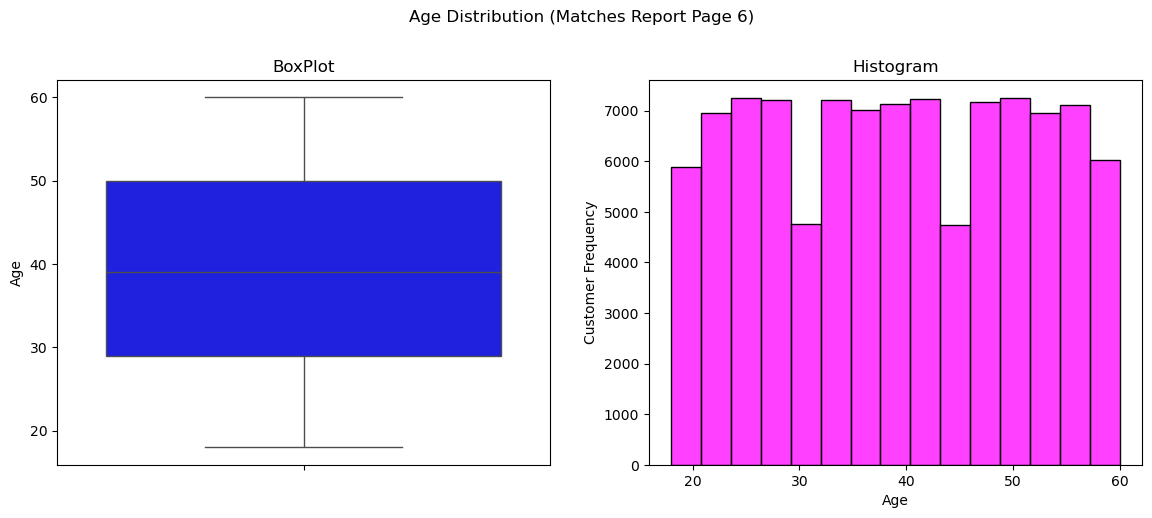


--- Gender Distribution ---
Gender
0    39875
1    60076


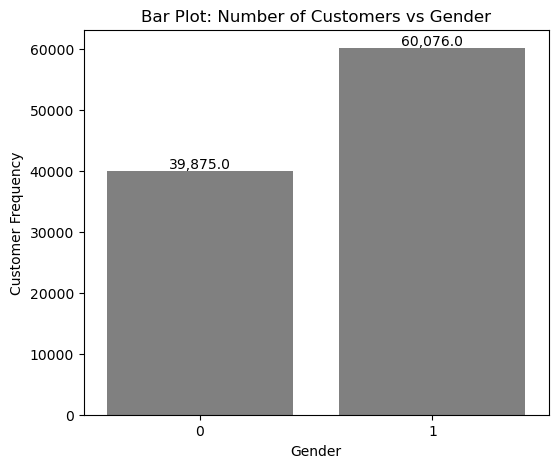


--- Marital Status Distribution ---
Marital_Status
0    23151
1    53966
2    22834


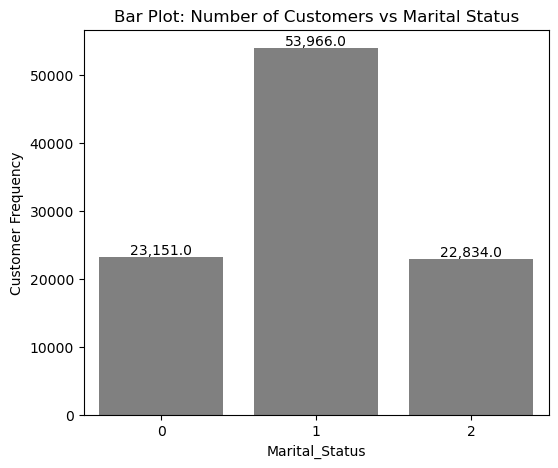


--- Education Distribution ---
Education
0    29616
1    13395
2    22530
3     7230
4    14739
5    12441


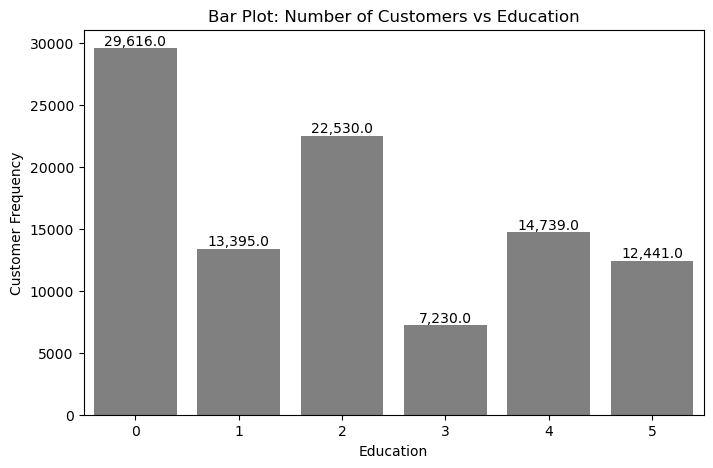


--- Rating Distribution ---
Rating
0    47576
1    22974
2    29401


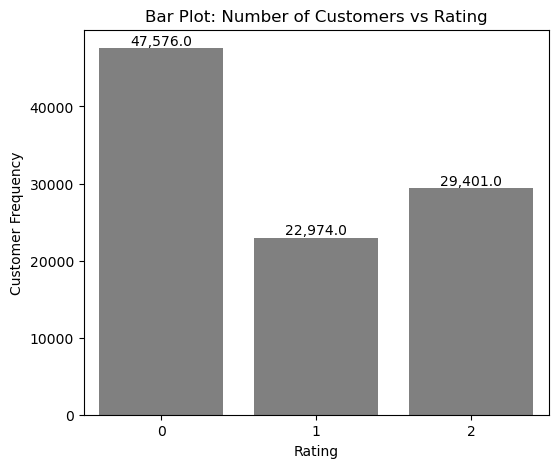

In [ ]:
# print(" Univariate Analysis Replication")

# # --- 2.1 Age Distribution () ---
# print("\n--- Age Statistics ---")
# print(f"Average Age of Customers is {data['Age'].mean():.0f} years")

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# fig.suptitle('Age Distribution (Matches Report Page 6)', y=1.02)

# # Box Plot
# sns.boxplot(y=data['Age'], ax=axes[0], color='blue')
# axes[0].set_title('BoxPlot')
# axes[0].set_ylabel('Age')

# # Histogram
# sns.histplot(data['Age'], bins=15, ax=axes[1], color='magenta', kde=False)
# axes[1].set_title('Histogram')
# axes[1].set_xlabel('Age')
# axes[1].set_ylabel('Customer Frequency')
# plt.show()


# # --- 2.2 Gender Distribution () ---
# print("\n--- Gender Distribution ---")
# gender_counts = data['Gender'].value_counts().sort_index()
# print(gender_counts.to_string())

# plt.figure(figsize=(6, 5))
# ax = sns.countplot(x='Gender', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Gender')
# plt.ylabel('Customer Frequency')
# plt.show()


# # --- 2.3 Marital Status Distribution () ---
# print("\n--- Marital Status Distribution ---")
# marital_counts = data['Marital_Status'].value_counts().sort_index()
# print(marital_counts.to_string())

# plt.figure(figsize=(6, 5))
# ax = sns.countplot(x='Marital_Status', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Marital Status')
# plt.ylabel('Customer Frequency')
# plt.show()


# # --- 2.4 Education Distribution () ---
# print("\n--- Education Distribution ---")
# edu_counts = data['Education'].value_counts().sort_index()
# print(edu_counts.to_string())

# plt.figure(figsize=(8, 5))
# ax = sns.countplot(x='Education', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Education')
# plt.ylabel('Customer Frequency')

# plt.show()


# # --- 2.5 Rating Distribution () ---
# print("\n--- Rating Distribution ---")
# rating_counts = data['Rating'].value_counts().sort_index()
# print(rating_counts.to_string())

# plt.figure(figsize=(6, 5))
# ax = sns.countplot(x='Rating', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Rating')
# plt.ylabel('Customer Frequency')

# plt.show()

In [ ]:
# 1. Overall Conversion Rate
total_customers = len(data)
conversion_rate = data['target'].mean() * 100
existing_customers_pct = (data['Current_Product'] == 1).sum() / total_customers * 100
new_customers_pct = (data['Current_Product'] == 0).sum() / total_customers * 100
male_pct = (data['Gender'] == 1).sum() / total_customers * 100
avg_age = data['Age'].mean()

print(f"Overall Conversion Rate (Converted=1): {conversion_rate:.2f}%")
print(f"Existing Customers: {existing_customers_pct:.2f}%")
print(f"New Customers (Targeted): {new_customers_pct:.2f}%")
print(f"Average Age: {avg_age:.2f}")
print(f"Percentage of Male Customers: {male_pct:.2f}%")

Overall Conversion Rate (Converted=1): 38.31%
Existing Customers: 57.13%
New Customers (Targeted): 42.87%
Average Age: 39.03
Percentage of Male Customers: 60.11%


In [4]:
cleaned_data = pd.read_excel(r"D:\Naresh IT\fwdinsuranceproject (1)\Data_cleaned.xlsx")

In [6]:
df = cleaned_data.copy()

--- Value Counts for 'Converted' ---
Converted
NotConverted    61677
Converted       38323
Name: count, dtype: int64

--- Percentage of 'Converted' ---
Converted
NotConverted   61.68
Converted      38.32
Name: proportion, dtype: float64


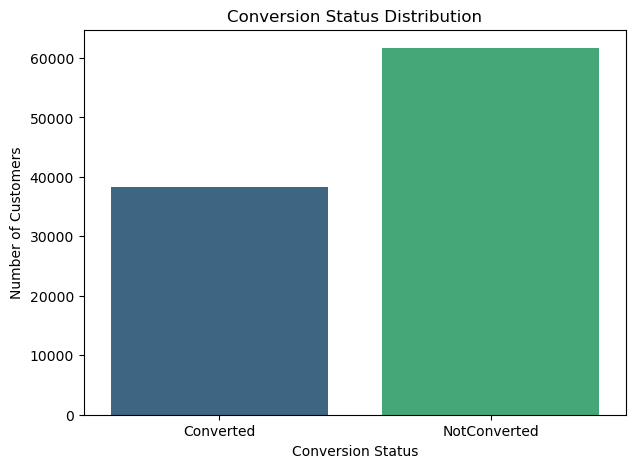

In [8]:
# 1A. Univariate Analysis - Target Variable 'Converted'

# Pandas: Value Counts and Percentage
conversion_counts = df['Converted'].value_counts()
conversion_percentages = df['Converted'].value_counts(normalize=True) * 100

print("--- Value Counts for 'Converted' ---")
print(conversion_counts)
print("\n--- Percentage of 'Converted' ---")
print(conversion_percentages)

# Seaborn/Matplotlib: Bar Plot for visualization
plt.figure(figsize=(7, 5))
sns.countplot(x='Converted', data=df, palette='viridis')
plt.title('Conversion Status Distribution')
plt.xlabel('Conversion Status')
plt.ylabel('Number of Customers')
# plt.savefig('converted_univariate_plot.png')
plt.show()

--- Descriptive Statistics for 'Income' ---
count   100000.00
mean         4.96
std          3.29
min          1.00
25%          2.03
50%          3.00
75%          9.10
max         10.00
Name: Income, dtype: float64


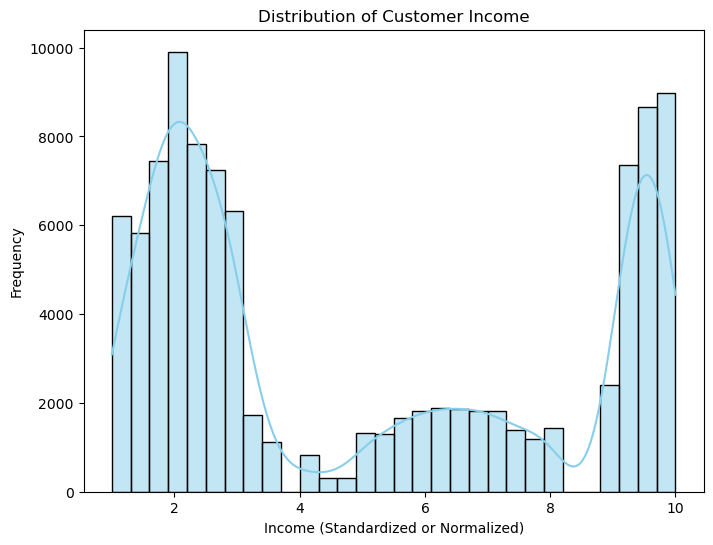

In [9]:
# 1B. Univariate Analysis - Continuous Variable 'Income'

# Pandas: Descriptive Statistics
print("--- Descriptive Statistics for 'Income' ---")
print(df['Income'].describe())

# Seaborn/Matplotlib: Histogram for visualization
plt.figure(figsize=(8, 6))
sns.histplot(df['Income'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Income')
plt.xlabel('Income (Standardized or Normalized)')
plt.ylabel('Frequency')
# plt.savefig('income_univariate_plot.png')
plt.show()

--- Value Counts for 'Rating' ---
Rating
Cold    47588
Warm    29423
Hot     22989
Name: count, dtype: int64

--- Percentage of 'Rating' ---
Rating
Cold   47.59
Warm   29.42
Hot    22.99
Name: proportion, dtype: float64


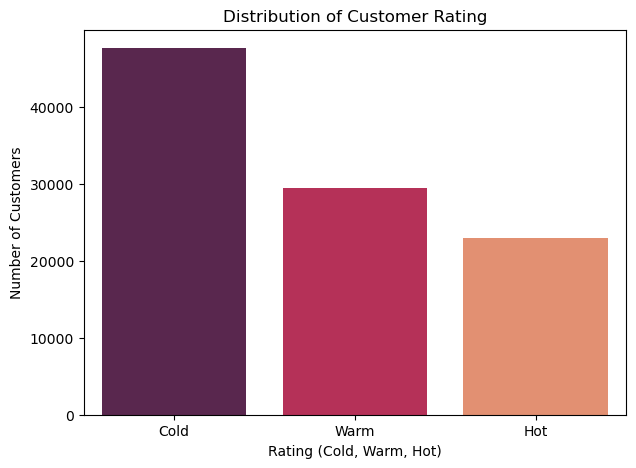

In [10]:
# 1C. Univariate Analysis - Categorical Variable 'Rating'

# Pandas: Value Counts and Percentage
rating_counts = df['Rating'].value_counts()
rating_percentages = df['Rating'].value_counts(normalize=True) * 100

print("--- Value Counts for 'Rating' ---")
print(rating_counts)
print("\n--- Percentage of 'Rating' ---")
print(rating_percentages)

# Seaborn/Matplotlib: Bar Plot for visualization
plt.figure(figsize=(7, 5))
sns.countplot(x='Rating', data=df, order=df['Rating'].value_counts().index, palette='rocket')
plt.title('Distribution of Customer Rating')
plt.xlabel('Rating (Cold, Warm, Hot)')
plt.ylabel('Number of Customers')
# plt.savefig('rating_univariate_plot.png')
plt.show()

--- Conversion Percentage by Customer Rating ---
Converted  Converted  NotConverted
Rating                            
Cold            4.86         95.14
Hot            89.87         10.13
Warm           52.16         47.84


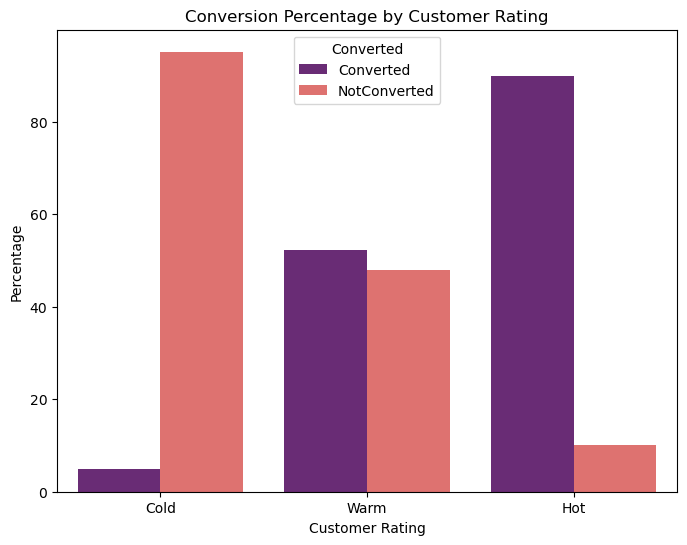

In [11]:
#Bivariate Analysis - Categorical vs. Target: Rating vs. Converted

conversion_rate_by_rating = pd.crosstab(df['Rating'], df['Converted'], normalize='index') * 100

print("--- Conversion Percentage by Customer Rating ---")
print(conversion_rate_by_rating)

# Seaborn/Matplotlib: Stacked Bar Chart for visualization
rating_conversion_df = df.groupby(['Rating', 'Converted']).size().reset_index(name='Count')
total_by_rating = rating_conversion_df.groupby('Rating')['Count'].transform('sum')
rating_conversion_df['Percentage'] = rating_conversion_df['Count'] / total_by_rating * 100

plt.figure(figsize=(8, 6))
sns.barplot(
    x='Rating',
    y='Percentage',
    hue='Converted',
    data=rating_conversion_df,
    order=['Cold', 'Warm', 'Hot'], # Ensure order is logical
    palette='magma'
)
plt.title('Conversion Percentage by Customer Rating')
plt.xlabel('Customer Rating')
plt.ylabel('Percentage')
plt.legend(title='Converted')
# plt.savefig('rating_conversion_bivariate_plot.png')
plt.show()

Look at the 'Converted' column in the crosstab output. You can clearly see the conversion rate for Cold, Warm, and Hot customers. A good rating system should show a clear increase in the conversion rate as the rating moves from 'Cold' $\rightarrow$ 'Warm' $\rightarrow$ 'Hot'.

--- Age Descriptive Statistics Grouped by Conversion Status ---
                count  mean   std   min   25%   50%   75%   max
Converted                                                      
Converted    38323.00 37.22 11.65 18.00 27.00 36.00 47.00 60.00
NotConverted 61677.00 40.15 12.26 18.00 29.00 41.00 51.00 60.00


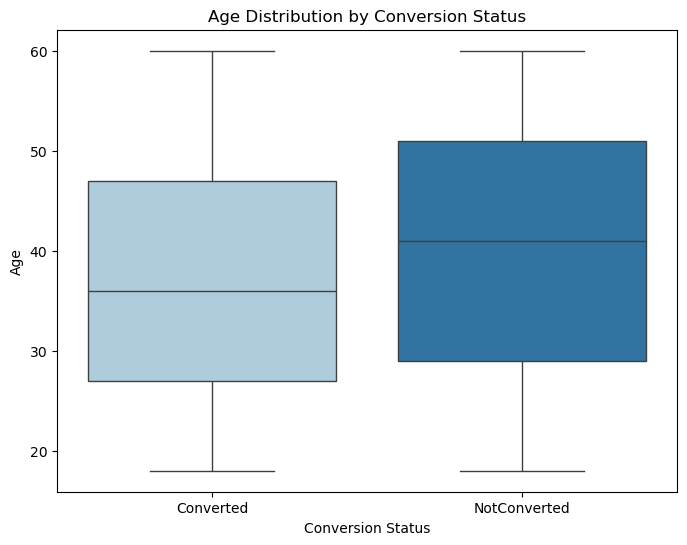

In [12]:
#  Bivariate Analysis - Continuous vs. Target: Age vs. Converted

# Pandas: Grouped Descriptive Statistics
print("--- Age Descriptive Statistics Grouped by Conversion Status ---")
print(df.groupby('Converted')['Age'].describe())

# Seaborn/Matplotlib: Box Plot for visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x='Converted', y='Age', data=df, palette='Paired')
plt.title('Age Distribution by Conversion Status')
plt.xlabel('Conversion Status')
plt.ylabel('Age')
# plt.savefig('age_conversion_bivariate_plot.png')
plt.show()

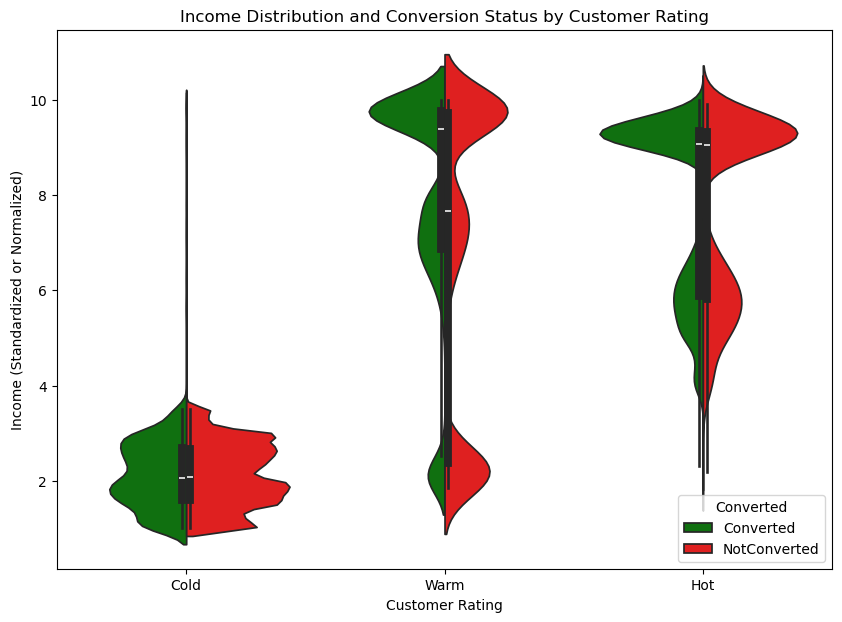

In [13]:
# 3. Multivariate Analysis - Income vs. Converted, grouped by Rating

# Seaborn/Matplotlib: Violin Plot for visualization
plt.figure(figsize=(10, 7))
sns.violinplot(
    x='Rating',
    y='Income',
    hue='Converted',
    data=df,
    order=['Cold', 'Warm', 'Hot'], # Ensure order is logical
    split=True, # Split the violins for better comparison
    palette={'Converted': 'green', 'NotConverted': 'red'}
)
plt.title('Income Distribution and Conversion Status by Customer Rating')
plt.xlabel('Customer Rating')
plt.ylabel('Income (Standardized or Normalized)')
plt.legend(title='Converted')
# plt.savefig('income_rating_conversion_multivariate_plot.png')
plt.show()

--- MEAN INCOME ANALYSIS: TOP EDUCATION AND EXISTING CUSTOMER STATUS ---
                                   count  mean  std  min  25%  50%  75%   max
Education Current_Product target                                             
MD        No              0      3857.00  3.40 2.66 1.50 1.89 2.28 2.89 10.00
                          1      5261.00  8.12 1.87 1.50 6.59 9.15 9.50 10.00
          Yes             0      7634.00  4.97 3.25 1.50 2.32 2.90 9.07 10.00
                          1      5778.00  8.22 1.92 1.50 6.79 9.24 9.60 10.00
PD        No              0      2461.00  3.38 2.60 1.50 1.90 2.32 2.86 10.00
                          1      3439.00  8.13 1.88 1.50 6.62 9.15 9.50 10.00
          Yes             0      4991.00  5.01 3.28 1.50 2.31 2.90 9.21 10.00
                          1      3848.00  8.18 1.94 1.50 6.78 9.23 9.58 10.00


ValueError: The palette dictionary is missing keys: {np.int64(0), np.int64(1)}

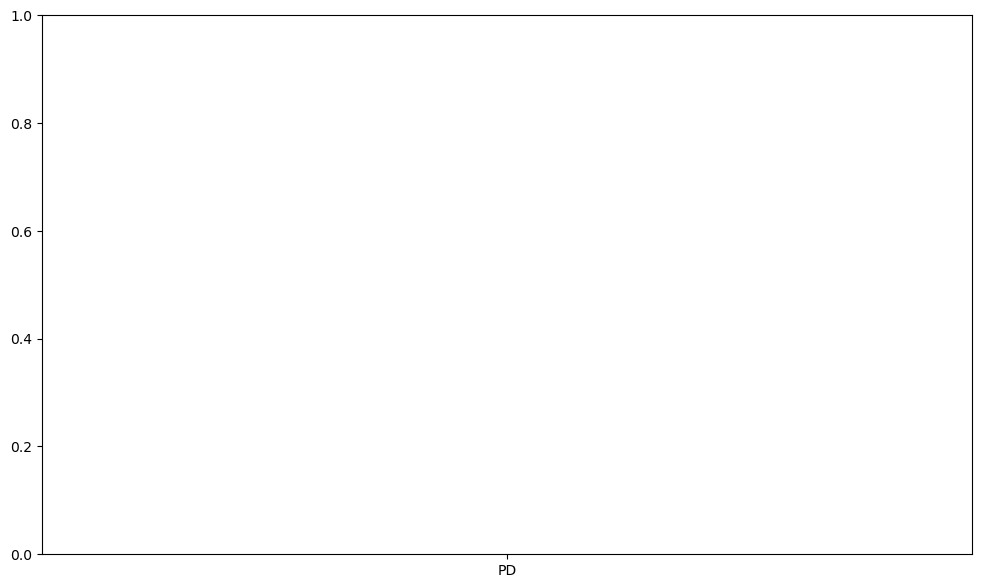

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded in the environment as 'df')
# If you run this code in a fresh environment, uncomment the line below:
df = pd.read_csv(r"C:\Users\vadla rajendraprasad\Downloads\cleaned_ins_data.csv")

# 1. Define the best-performing education levels based on Bivariate analysis
top_education_levels = ['PD', 'MD']
df_filtered = df[df['Education'].isin(top_education_levels)].copy()

# 2. Grouped statistics for the most actionable segment:
# Check the mean income for conversion status, grouped by Current_Product and Education
# This generates the exact numbers used to confirm the "High-Income converts" rule.
income_conversion_stats = df_filtered.groupby(['Education', 'Current_Product', 'target'])['Income'].describe()

print("--- MEAN INCOME ANALYSIS: TOP EDUCATION AND EXISTING CUSTOMER STATUS ---")
print(income_conversion_stats)

# 3. Seaborn/Matplotlib: Violin Plot for clear visualization
# This plot visually confirms that the 'Converted' group (green) has a higher income distribution.
plt.figure(figsize=(12, 7))
sns.violinplot(
    x='Education',
    y='Income',
    hue='target',
    data=df_filtered,
    split=True,
    inner='quartile', # Shows the median and quartiles
    palette={'target': 'green', 'NotConverted': 'red'},
    order=top_education_levels
)
plt.title('Income Distribution and Conversion Status for Top Education Levels (PD, MD)')
plt.xlabel('Education Level')
plt.ylabel('Income (Standardized or Normalized)')
plt.legend(title='Converted Status')
plt.savefig('multivariate_income_education_converted_plot.png')
plt.close()

print("\nCode complete. The plot 'multivariate_income_education_converted_plot.png' was saved.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r"C:\Users\vadla rajendraprasad\Downloads\cleaned_ins_data.csv"
df = pd.read_csv(file_path)

df.rename(columns = {'target':'Converted'})


In [210]:
df.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,target
0,18.00,M,Single,3.00,NE,SPT,DD,1.00,No,NO,0.00,INV,15000000.00,Cold,1
1,46.00,M,Married,5.00,PD,SE,FH,2.51,Yes,TLE,50000.00,ANS,2000000.00,Cold,0
2,23.00,M,Married,2.00,BD,SPT,PG,9.00,No,NO,0.00,ANS,1000000.00,Hot,1
3,20.00,M,Single,6.00,NE,SPT,OM,2.42,No,NO,0.00,END,1000000.00,Warm,1
4,48.00,M,Married,4.00,BD,SPT,PG,9.64,Yes,ANS,15000000.00,INV,15000000.00,Warm,0


In [ ]:
# --- A. Target Variable: Converted ---
print("--- 1A. Univariate Analysis: Converted Status ---")
conversion_counts = df['Converted'].value_counts()
conversion_percentages = df['Converted'].value_counts(normalize=True) * 100
print(conversion_counts)
print("\nPercentage:")
print(conversion_percentages)

In [ ]:


# Visualization
plt.figure(figsize=(7, 5))
sns.countplot(x='Converted', data=df, palette='viridis')
plt.title('Conversion Status Distribution')
plt.savefig('1A_converted_univariate.png')
plt.close()

# --- B. Continuous Variable: Income ---
print("\n--- 1B. Univariate Analysis: Income ---")
print(df['Income'].describe())

# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(df['Income'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Income')
plt.savefig('1B_income_univariate.png')
plt.close()

# --- C. Categorical Variable: Rating ---
print("\n--- 1C. Univariate Analysis: Rating ---")
print(df['Rating'].value_counts())

# Visualization
plt.figure(figsize=(7, 5))
sns.countplot(x='Rating', data=df, order=df['Rating'].value_counts().index, palette='rocket')
plt.title('Distribution of Customer Rating')
plt.savefig('1C_rating_univariate.png')
plt.close()